<a href="https://colab.research.google.com/github/radhaprashanthi/Single-Image-Super-Resolution/blob/master/01_srgan_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SRGAN Trial

https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4

In [0]:
from torch import nn
from torch.nn import functional as F

from PIL import Image
from torch.utils.data.dataset import Dataset
from torch.utils.data import Sampler
from torchvision.transforms import (Compose, RandomCrop, ToTensor,
                                    ToPILImage, CenterCrop, Resize)

import torch
import torchvision
import math
import numpy as np
from glob import glob

from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import (
    Compose, RandomCrop, ToTensor,
    ToPILImage, CenterCrop, Resize,
    RandomHorizontalFlip, RandomVerticalFlip)
from pathlib import Path
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# %%writefile setup.sh

# rm -rf apex
# git clone https://github.com/NVIDIA/apex
# pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

In [0]:
# !sh setup.sh

![alt text](https://i.ibb.co/JQ9JL2t/image.png)

![alt text](https://i.ibb.co/Tcmfjjn/image.png)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
class Generator(nn.Module):
    """
    """
    def __init__(self, upscale_factor=4, image_channels=3,
                 residual_block_channels=64,
                 num_residual_blocks=5):
        super().__init__()
        self.upscale_factor=upscale_factor
        self.image_channels = image_channels
        self.residual_block_channels = residual_block_channels
        self.num_residual_blocks = num_residual_blocks

        # k9n64s1
        initial_block_param = {
            "in_channels": image_channels,
            "kernel_size": 9,
            "out_channels": residual_block_channels,
            "stride": 1,
            "padding": 9 // 2
        }
        self.initial_block = nn.Sequential(
            nn.Conv2d(**initial_block_param),
            nn.PReLU()       
        )

        self.residual_blocks = nn.Sequential(
            *[ResidualBlock(channels=residual_block_channels) 
            for _ in range(num_residual_blocks)]
        )

        self.skip_block = SkipBlock(channels=residual_block_channels)

        # two trained sub-pixel convolution layers
        num_spcn_blocks = int(math.log(upscale_factor, 2))
        self.spcn_blocks = nn.Sequential(
            *[SPCNBlock(in_channels=residual_block_channels,
                       upscale_factor=2) 
            for _ in range(num_spcn_blocks)]
        )

        #  k9n3s1
        final_block_param = {
            "in_channels": residual_block_channels,
            "kernel_size": 9,
            "out_channels": image_channels,
            "stride": 1,
            "padding": 9 // 2
        }
        self.final_block = nn.Conv2d(**final_block_param)

    def forward(self, x):
        initial_out = self.initial_block(x)
        B_residual_out = self.residual_blocks(initial_out)
        skip_out = self.skip_block(B_residual_out,
                                   initial_out)
        spcn_out = self.spcn_blocks(skip_out)
        pixels = self.final_block(spcn_out)
        # tanh to squish => [-1, 1]
        # add 1          => [0, 2]
        # divide by 2    => [0, 1] 
        out = (torch.tanh(pixels) + 1) / 2

        return out
    
class ResidualBlock(nn.Module):
    """
    At the core of our very deep generator network G, which
    is illustrated in Figure 4 are B residual blocks with identical
    layout. Inspired by Johnson et al. [33] we employ the block
    layout proposed by Gross and Wilber [24]. Specifically, we
    use two convolutional layers with small 3×3 kernels and 64
    feature maps followed by batch-normalization layers [32]
    and ParametricReLU [28] as the activation function.

    k3n64s1 => 
        kernel_size = 3,
        channels = 64,
        stride = 1
    """
    
    def __init__(self, channels=64, kernel_size=3, stride=1):
        super().__init__()
        padding = 3 // 2
        self.conv1 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=channels)
        self.prelu = nn.PReLU()

        self.conv2 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn2 = nn.BatchNorm2d(num_features=channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        # Element-wise sum
        return residual + x


class SkipBlock(nn.Module):
    """
    k3n64s1 => 
        kernel_size = 3,
        channels = 64,
        stride = 1
    """

    def __init__(self, channels=64, kernel_size=3, stride=1):
        super().__init__()
        padding = 3 // 2
        self.conv1 = nn.Conv2d(in_channels=channels,
                            out_channels=channels,
                            kernel_size=kernel_size,
                            padding=padding,
                            stride=stride)
        self.bn1 = nn.BatchNorm2d(num_features=channels)

    def forward(self, x, img):
        residual = self.conv1(x)
        residual = self.bn1(residual)

        # Element-wise sum
        return residual + img

class SPCNBlock(nn.Module):
    """
    SPCN - sub-pixel convolutional neural network
    We increase the resolution of the input image with two trained
    sub-pixel convolution layers as proposed by Shi et al. [48].

    https://arxiv.org/pdf/1609.05158.pdf

    k3n256s1 => 
        kernel_size = 3,
        channels = 256, (64 * (2 ** 2))
        stride = 1
    """
    def __init__(self, in_channels, 
                upscale_factor=2,
                kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                            out_channels=in_channels * (upscale_factor ** 2),
                            kernel_size=kernel_size,
                            padding=kernel_size // 2)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor=upscale_factor)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)

        return x

In [0]:
def save_checkpoint(model, filepath):
    
    checkpoint = {'upscale_factor': model.upscale_factor,
                  'image_channels': model.image_channels,
                  'residual_block_channels': model.residual_block_channels,
                  'num_residual_blocks': model.num_residual_blocks,
                  'state_dict': model.state_dict()}

    torch.save(checkpoint, filepath)



def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = Generator(checkpoint['upscale_factor'],
                      checkpoint['image_channels'],
                      checkpoint['residual_block_channels'],
                      checkpoint['num_residual_blocks'])
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

In [6]:
upscale_factor=4
image_channels=3
residual_block_channels=64
num_residual_blocks=5

generator = Generator(upscale_factor=upscale_factor,
                      image_channels=image_channels,
                      residual_block_channels=residual_block_channels,
                      num_residual_blocks=num_residual_blocks).to(device)
generator

Generator(
  (initial_block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): PReLU(num_parameters=1)
  )
  (residual_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (prelu): PReLU(num_parameters=1)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [7]:
sum(param.numel() for param in generator.parameters())

734219

In [0]:
def max_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        ToTensor(),
    ])

def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])


class SRImageDataset(Dataset):
    def __init__(self, dataset_dir, 
                 crop_size=100, 
                 upscale_factor=4):
        super().__init__()
        glob_path = str(Path(dataset_dir) / "*[.jpg, .png]")
        crop_size = max_crop_size(crop_size, upscale_factor)
        
        self.image_filenames = glob(glob_path)[:1000]
        
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

In [0]:
train_dataset = SRImageDataset(
    dataset_dir="/content/drive/My Drive/Colab Notebooks/sr/training_data",
    crop_size=32
)

valid_dataset = SRImageDataset(
    dataset_dir="/content/drive/My Drive/Colab Notebooks/sr/DIV2K_valid_HR",
    crop_size=500
)

In [0]:
# class RandomSampler(Sampler):
#     def __init__(self, data, data_len=1000):
#         self.data = data
#         self.num_samples = len(data)
#         self.data_len = data_len

#     def __iter__(self):
#         return np.random.choice(self.data,
#                                 self.data_len)

#     def __len__(self):
#         return self.data_len

# random_sampler = RandomSampler(data=train_dataset, data_len=1000)

In [15]:
train_dataloader = DataLoader(
    dataset=train_dataset, batch_size=200,
    num_workers=4
)
valid_dataloader = DataLoader(
    dataset=valid_dataset, batch_size=10,
    num_workers=4
)

len(train_dataloader), len(valid_dataloader)

(5, 10)

In [0]:
def cosine_segment(start_lr, end_lr, iterations):
    i = np.arange(iterations)
    c_i = 1 + np.cos(i*np.pi/iterations)
    return end_lr + (start_lr - end_lr)/2 *c_i

def get_cosine_triangular_lr(max_lr, iterations, div_start=5, div_end=5):
    min_start, min_end = max_lr/div_start, max_lr/div_end
    iter1 = int(0.3*iterations)
    iter2 = iterations - iter1
    segs = [cosine_segment(min_start, max_lr, iter1), cosine_segment(max_lr, min_end, iter2)]
    return np.concatenate(segs)

def update_optimizer(optimizer, lr):
    for i, param_group in enumerate(optimizer.param_groups):
        param_group["lr"] = lr

In [0]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    y_hat = []
    ys = []
    for lr, hr in valid_dl:
        lr, hr = lr.to(device), hr.to(device)
        batch = hr.shape[0]
        out = model(lr) #.cuda()
        loss = F.mse_loss(out, hr) #.cuda()
        sum_loss += batch*(loss.item())
        total += batch

    return sum_loss/total

def train_model(model, train_dl, valid_dl, optimizer, max_lr=0.05, epochs=100):
    iterations = epochs * len(train_dl)
    pbar = tqdm(total=iterations)
    idx = 0
    best_val_r2 = 0
    lrs = get_cosine_triangular_lr(max_lr, iterations)
    for t in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for lr, hr in train_dl:
            lr, hr = lr.to(device), hr.to(device)
            update_optimizer(optimizer, lrs[idx])
            batch_size = hr.size(0)
            y_hr = model(lr)
            # loss = F.mse_loss(y_hr, hr)
            loss = F.mse_loss(y_hr * 255, hr * 255)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * batch_size
            total += batch_size
            idx +=1
            pbar.update()
        val_loss = val_metrics(model, valid_dl)


        print(f"Training Loss: {total_loss/total}, Valid Loss: {val_loss}")
            
    return 0

In [0]:
parameters = [param for param in generator.parameters() if  param.requires_grad]

optimizer = torch.optim.Adam(parameters, lr=0.5, weight_decay=1e-5)

In [0]:
PATH = Path("/content/drive/My Drive/Colab Notebooks/DL/final_project/aishu/models")
os.makedirs(PATH, exist_ok=True)
save_checkpoint(generator, PATH / "checkpoint.pth")

In [32]:
train_model(generator, train_dataloader,
            valid_dataloader, optimizer, epochs=2)

Training Loss: 10215.5380859375, Valid Loss: 0.40257432758808137
Training Loss: 8958.26796875, Valid Loss: 0.3154928982257843


0

In [0]:
example, hr = valid_dataset[9]

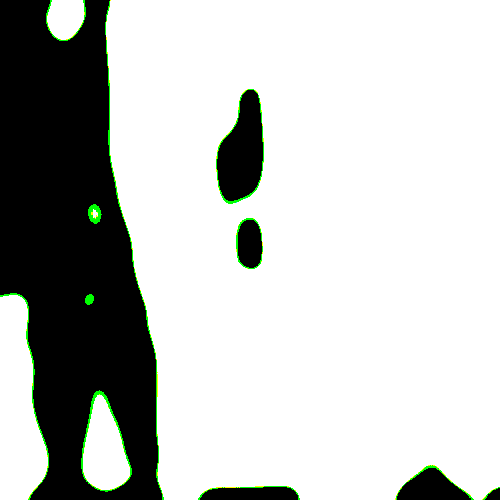

In [34]:
ToPILImage()(generator(example.unsqueeze(0).to(device)).to("cpu").squeeze(0))

In [35]:
out = generator(example.unsqueeze(0).to(device)).to("cpu").squeeze(0)
F.mse_loss(out, hr)

tensor(0.2985, grad_fn=<MseLossBackward>)

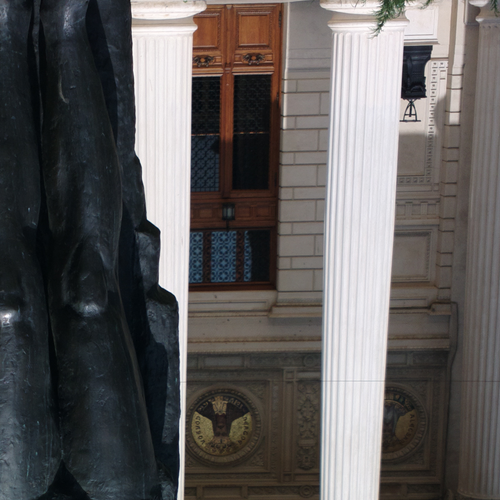

In [36]:
ToPILImage()(hr)